# Packages

In [1]:
%%capture

# konlpy on colab
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
# kerastuner
!pip install keras-tuner
# Pororo for summarization
!pip install pororo

In [2]:
%%capture

# 코랩 한글 폰트 깨짐 방지
# 실행 후 런타임 다시 시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [9]:
import os
import random
import re
import requests
import time
import pickle

import pandas as pd
import numpy as np
from collections import Counter

from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import IPython
from wordcloud import WordCloud

from konlpy.tag import Mecab
import konlpy
from pororo import Pororo

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.externals import joblib

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, SpatialDropout1D, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import kerastuner as kt

plt.rc('font', family='NanumBarunGothic') # matplotlib 기본 폰트 설정
os.chdir('/content/drive/MyDrive/project#1') # 코랩 디렉토리 기본 경로 수정

# Set seed
random.seed(34)
np.random.seed(34)
os.environ['PYTHONHASHSEED'] = str(34)
os.environ['TF_DETERMINISTIC_OPS'] = str(34)
tf.random.set_seed(34)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Data gathering
여러개의 디렉토리에 분할되어 있는 데이터 합치기

In [ ]:
target_dir = 'data/HKIB-20000' # 데이터가 있는 디렉토리
cat_dirs = ['healths', 'economy', 'science', 'education', 'culture', 'society', 'industry', 'leisure', 'politics'] # 만들 디렉토리
cat_prefixes = ['건강', '경제', '과학', '교육', '문화', '사회', '산업', '여가', '정치'] # 문서 카테고리

files = os.listdir(target_dir)
files
# 03년, 07년에 분할된 카테고리가 있음
# 07년으로 사용

['HKIB-20000_001.txt',
 'HKIB-20000_002.txt',
 'HKIB-20000_003.txt',
 'HKIB-20000_004.txt',
 'HKIB-20000_005.txt',
 'hkib20000-cat03-all.categories',
 'hkib20000-cat03-file1.categories',
 'hkib20000-cat03-file2.categories',
 'hkib20000-cat03-file3.categories',
 'hkib20000-cat03-file4.categories',
 'hkib20000-cat03-file5.categories',
 'hkib20000-cat07-file1.categories',
 'hkib20000-cat07-file2.categories',
 'hkib20000-cat07-file3.categories',
 'hkib20000-cat07-file4.categories',
 'hkib20000-cat07-file5.categories',
 'hkib20000-cat07-all.categories']

In [ ]:
# 분할되어 있는 .txt 파일을 돌아가면서 처리
for f in files: 
    if not f.endswith('.txt'):
        continue
    
    # 각 txt 파일을 열어보고 처리
    with open(target_dir + '/' + f) as currfile:
        doc_cnt = 0
        docs = []
        curr_doc = None

        # 기사(@DOCUMENT) 단위로 나누어 docs 리스트 생성
        for curr_line in currfile:
            if curr_line.startswith('@DOCUMENT'):
                if curr_doc is not None:
                    docs.append(curr_doc)
                curr_doc = curr_line
                doc_cnt = doc_cnt + 1
                continue
            curr_doc = curr_doc + curr_line
        
        # docs 리스트 내 기사의 카테고리 분류
        for doc in docs:
            doc_lines = doc.split('\n')
            doc_no = doc_lines[1][9:]

            doc_cat07 = ''
            for line in doc_lines[:10]:
                if line.startswith("#CAT'07:"): # 기사 내 카테고리가 명시된 부분
                    doc_cat07 = line[10:]
                    break

            # 주제별 디렉토리 정리
            for cat_prefix in cat_prefixes: # 사전에 정의해 둔 카테고리 목록 ['건강', '경제', '과학', '교육', '문화', '사회', '산업', '여가', '정치']
                if doc_cat07.startswith(cat_prefix):
                    dir_index = cat_prefixes.index(cat_prefix)
                    break
            
            # 기사 본문만 추출해서 디렉토리 별로 정리
            filtered_lines = []
            for line in doc_lines:
                if not (line.startswith('#') or line.startswith('@')):
                    filtered_lines.append(line)
            
            filename = 'hkib-' + doc_no + '.txt'
            filepath = target_dir + '/' + cat_dirs[dir_index]

            if not os.path.exists(filepath):
                os.makedirs(filepath)

            f = open(filepath + '/' + filename, 'w')
            f.write('\n'.join(filtered_lines))
            f.close()

In [ ]:
# 카테고리 별 디렉토리에 담긴 문서를 읽고 반환하는 함수
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        doc = f.read()
        return doc

In [ ]:
categories = []
docs = []

for cat in cat_dirs:
    dir_path = f'data/HKIB-20000/{cat}'
    
    for filename in os.listdir(dir_path):
        docs.append(read_text_file(dir_path + '/' + filename))
        categories.append(cat)

In [ ]:
len(docs), len(categories)

In [ ]:
# 하나의 데이터프레임으로 생성
data = pd.DataFrame(columns=['document', 'category'])
data['document'] = docs
data['category'] = categories

data.head(10)

In [ ]:
# 데이터 shuffle
data = data.sample(frac=1).reset_index(drop='index')
data.head(10)

In [ ]:
data.to_csv('data.csv', index_label=False)

# Data(.csv) load

In [13]:
data = pd.read_csv('data.csv')
print(data.shape)
data.head()

(18784, 2)


,document,category
0,여성 특유의 감성세계를 그리거나 성차별을 고발하는 내용을 담은 여성\n 취향 ...,culture
1,특별검사에 강원일-최병모\n<!-search 199910070941:hk:10:::...,society
2,새해들어 주식시장의 기관장세화가 더욱 심화되고 있는 것으로 나타났다.\n ...,economy
3,정부는 8일 오전 이회창총리 주재로 국무회의를 열고 우루과이라운드(UR)\n ...,economy
4,서울과 부산지하철노조가 23일 오전부터 준법운행(규정준수운행)에\n 들어간 가...,society


In [ ]:
# 한국어 불용어 사전 생성
stop_words = pd.read_csv('한국어불용어100.txt', sep='\t', header=None)
stop_words = stop_words[0].tolist()
add_stop_words = ['에서', '의', '을', '를', '이', '가', '는', '은', 'search']

for word in add_stop_words:
    stop_words.append(word)

stop_words = list(set(stop_words))

# mecab 사전
mecab = Mecab()

In [ ]:
def text_preprocessing(text):
    txt = re.sub('[^가-힣a-zA-Z ]', '', text)
    txt = re.sub('[ ]+', ' ', txt)
    # txt = re.sub('[search,hk]', '', txt)
    return txt

def text_to_morphs(text, tokenizer):
    morphs = tokenizer.morphs(text)
    tokens = [m for m in morphs if m not in stop_words]
    return tokens

In [ ]:
data['doc_clean'] = data['document'].apply(text_preprocessing)

In [ ]:
%%time

data['tokens'] = data['doc_clean'].apply(lambda x: text_to_morphs(x, mecab))

CPU times: user 46.1 s, sys: 268 ms, total: 46.4 s
Wall time: 46.2 s


In [ ]:
data.head()

,document,category,doc_clean,tokens
0,여성 특유의 감성세계를 그리거나 성차별을 고발하는 내용을 담은 여성\n 취향 ...,culture,여성 특유의 감성세계를 그리거나 성차별을 고발하는 내용을 담은 여성 취향 영화가 ...,"[여성, 특유, 감성, 세계, 그리, 거나, 성, 차별, 고발, 내용, 담, 여성,..."
1,특별검사에 강원일-최병모\n<!-search 199910070941:hk:10:::...,society,특별검사에 강원일최병모 김대통령 임명일후 본격수사 착수 김대중 대통령은 일 조폐공...,"[특별, 검사, 에, 강원일, 최병모, 김, 대통령, 임명, 일후, 본격, 수사, ..."
2,새해들어 주식시장의 기관장세화가 더욱 심화되고 있는 것으로 나타났다.\n ...,economy,새해들어 주식시장의 기관장세화가 더욱 심화되고 있는 것으로 나타났다 일 증권업계에...,"[새해, 어, 주식, 시장, 기관장, 세화, 더욱, 심화, 고, 으로, 나타났, 다..."
3,정부는 8일 오전 이회창총리 주재로 국무회의를 열고 우루과이라운드(UR)\n ...,economy,정부는 일 오전 이회창총리 주재로 국무회의를 열고 우루과이라운드UR 협상에 따른 ...,"[정부, 오전, 이회창, 총리, 주재, 로, 국무, 회의, 열, 고, 우루과이, 라..."
4,서울과 부산지하철노조가 23일 오전부터 준법운행(규정준수운행)에\n 들어간 가...,society,서울과 부산지하철노조가 일 오전부터 준법운행규정준수운행에 들어간 가운데 경찰이 이...,"[서울, 과, 부산, 지하철, 노조, 오전, 부터, 준법, 운행, 규정, 준수, 운..."


# EDA

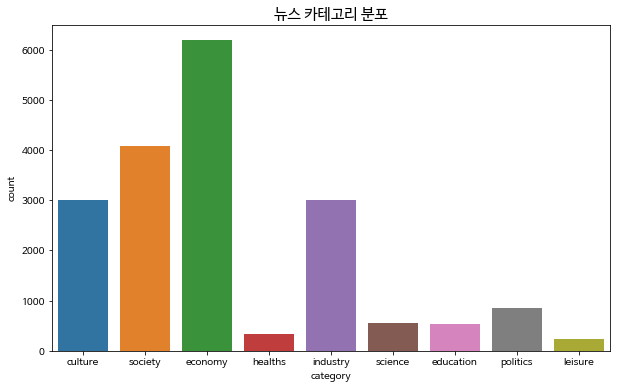

economy      6188
society      4071
culture      3008
industry     2996
politics      860
science       548
education     540
healths       331
leisure       242
Name: category, dtype: int64


In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x=data['category'])
plt.title('뉴스 카테고리 분포', size=15)
plt.show();

print(data['category'].value_counts())

🔥🔥🔥 

카테고리가 상당히 불균형함

경제, 사회, 문화, 산업 순으로 가장 많은 기사가 있고, 여가, 건강, 교육 등의 기사는 매우 적은 수를 보임

우리가 관심분야가 아닌 무의식 중에 평소 접하는 기사 중 대부분도 경제,사회,문화 등의 주제인 것과 같은 맥락으로 볼 수 있음

🔥🔥🔥 

불균형한 카테고리가 텍스트 분류 문제에서 큰 문제가 없을 지 조사가 필요

==> Imbalanced한 데이터를 다루기 위한 여러가지 방법이 있음. 일단 원본 데이터로 파이프라인을 구축해보고 Resampling, SMOTE 등의 방법을 적용한 후에 비교해 볼 것

🔥🔥🔥 

너무 적은 샘플을 가진 카테고리를 합쳐줄 수 있을 것 같음

> culture + leisure + education => 생활/문화

> healths + science => 과학/건강

> politics + society => 정치/사회

> economy + industry => 경제/산업





In [ ]:
def category_sum(text):
    if (text=='culture') or (text=='leisure') or (text=='education'):
        text = '생활/문화'

    elif (text=='healths') or (text=='science'):
        text = '과학/건강'
    
    elif (text=='politics') or (text=='society'):
        text = '정치/사회'
    
    elif (text=='economy') or (text=='industry'):
        text = '경제/산업'

    return text

In [ ]:
data['category'] = data['category'].apply(category_sum)
data['category'].unique()

array(['생활/문화', '정치/사회', '경제/산업', '과학/건강'], dtype=object)

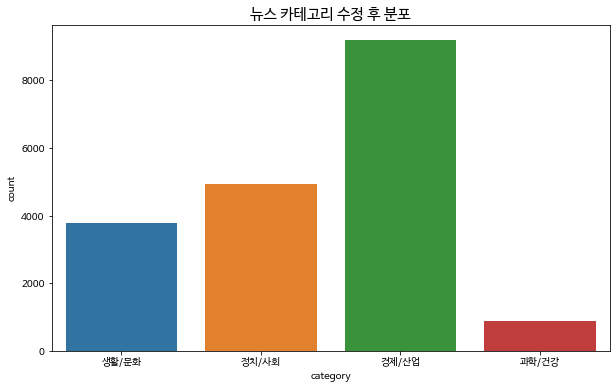

경제/산업    9184
정치/사회    4931
생활/문화    3790
과학/건강     879
Name: category, dtype: int64


In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x=data['category'])
plt.title('뉴스 카테고리 수정 후 분포', size=15)
plt.show();

print(data['category'].value_counts())

In [ ]:
data.head()

,document,category,doc_clean,tokens
0,여성 특유의 감성세계를 그리거나 성차별을 고발하는 내용을 담은 여성\n 취향 ...,생활/문화,여성 특유의 감성세계를 그리거나 성차별을 고발하는 내용을 담은 여성 취향 영화가 ...,"[여성, 특유, 감성, 세계, 그리, 거나, 성, 차별, 고발, 내용, 담, 여성,..."
1,특별검사에 강원일-최병모\n<!-search 199910070941:hk:10:::...,정치/사회,특별검사에 강원일최병모 김대통령 임명일후 본격수사 착수 김대중 대통령은 일 조폐공...,"[특별, 검사, 에, 강원일, 최병모, 김, 대통령, 임명, 일후, 본격, 수사, ..."
2,새해들어 주식시장의 기관장세화가 더욱 심화되고 있는 것으로 나타났다.\n ...,경제/산업,새해들어 주식시장의 기관장세화가 더욱 심화되고 있는 것으로 나타났다 일 증권업계에...,"[새해, 어, 주식, 시장, 기관장, 세화, 더욱, 심화, 고, 으로, 나타났, 다..."
3,정부는 8일 오전 이회창총리 주재로 국무회의를 열고 우루과이라운드(UR)\n ...,경제/산업,정부는 일 오전 이회창총리 주재로 국무회의를 열고 우루과이라운드UR 협상에 따른 ...,"[정부, 오전, 이회창, 총리, 주재, 로, 국무, 회의, 열, 고, 우루과이, 라..."
4,서울과 부산지하철노조가 23일 오전부터 준법운행(규정준수운행)에\n 들어간 가...,정치/사회,서울과 부산지하철노조가 일 오전부터 준법운행규정준수운행에 들어간 가운데 경찰이 이...,"[서울, 과, 부산, 지하철, 노조, 오전, 부터, 준법, 운행, 규정, 준수, 운..."


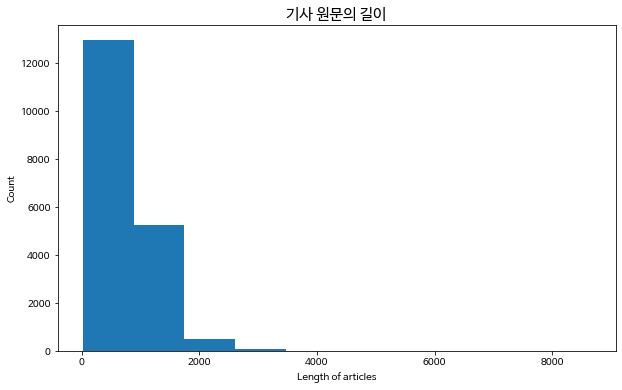

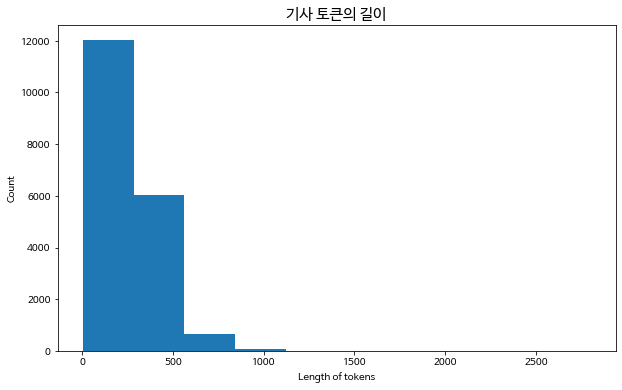

In [ ]:
# 기사 원문의 길이 분포
plt.figure(figsize=(10,6))
plt.hist([len(doc) for doc in data['doc_clean']])
plt.title('기사 원문의 길이', size=15)
plt.ylabel('Count')
plt.xlabel('Length of articles')
plt.show();

# 토큰의 길이 분포
plt.figure(figsize=(10, 6))
plt.hist([len(token) for token in data['tokens']])
plt.title('기사 토큰의 길이', size=15)
plt.ylabel('Count')
plt.xlabel('Length of tokens')
plt.show();

🔥🔥🔥 기사 원문과 형태소 토큰 길이의 분포는 큰 차이가 없음

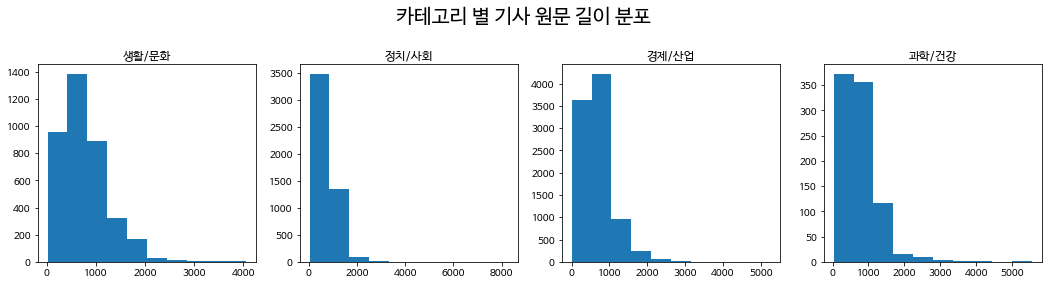

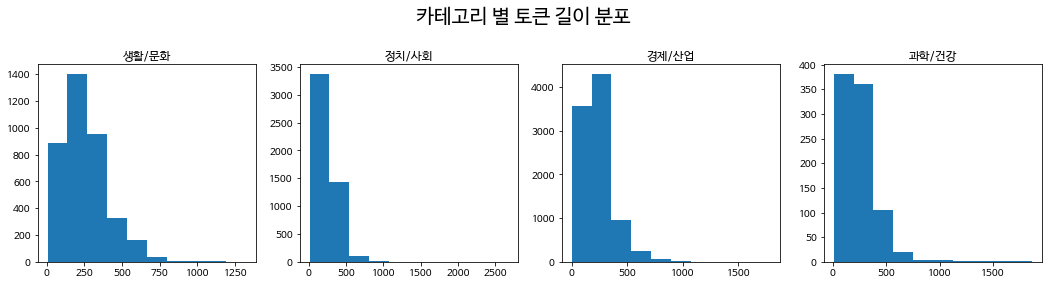

In [ ]:
# 카테고리별 기사 원문 길이 분포
plt.figure(figsize=(18, 8))

plot_location = 1
for category in data['category'].unique().tolist():
    plt.subplot(2, 4, plot_location)
    plt.title(f'{category}')
    plt.hist([len(doc) for doc in data[data['category']==category]['doc_clean']])
    plt.suptitle('카테고리 별 기사 원문 길이 분포', size = 20)
    plot_location += 1
plt.figure(figsize=(18, 8))

# 카테고리별 토큰 길이 분포
plot_location = 1
for category in data['category'].unique().tolist():
    plt.subplot(2, 4, plot_location)
    plt.title(f'{category}')
    plt.hist([len(token) for token in data[data['category']==category]['tokens']])
    plt.suptitle('카테고리 별 토큰 길이 분포', size=20)
    plot_location += 1

In [ ]:
maxlen = max([len(token) for token in data['tokens']])
meanlen = np.mean([len(token) for token in data['tokens']])

maxlen, meanlen

(2677, 240.08970400340715)

🔥🔥🔥 

전체 토큰 중 최대 길이는 2799개, 평균은 260개

전체 기사의 토큰은 약 200~400 정도의 길이임을 확인할 수 있음

In [ ]:
# 정수로 이루어진 타겟 클래스 칼럼 생성
categories_lst = data['category'].unique().tolist()

def category_to_num(category):
    for i, j in enumerate(categories_lst):
        if j == category:
            return i

data['class'] = data['category'].apply(category_to_num)

print(categories_lst)
print(data['category'].value_counts())
print(data['class'].value_counts())

['생활/문화', '정치/사회', '경제/산업', '과학/건강']
경제/산업    9184
정치/사회    4931
생활/문화    3790
과학/건강     879
Name: category, dtype: int64
2    9184
1    4931
0    3790
3     879
Name: class, dtype: int64


In [ ]:
data.head()

,document,category,doc_clean,tokens,class
0,여성 특유의 감성세계를 그리거나 성차별을 고발하는 내용을 담은 여성\n 취향 ...,생활/문화,여성 특유의 감성세계를 그리거나 성차별을 고발하는 내용을 담은 여성 취향 영화가 ...,"[여성, 특유, 감성, 세계, 그리, 거나, 성, 차별, 고발, 내용, 담, 여성,...",0
1,특별검사에 강원일-최병모\n<!-search 199910070941:hk:10:::...,정치/사회,특별검사에 강원일최병모 김대통령 임명일후 본격수사 착수 김대중 대통령은 일 조폐공...,"[특별, 검사, 에, 강원일, 최병모, 김, 대통령, 임명, 일후, 본격, 수사, ...",1
2,새해들어 주식시장의 기관장세화가 더욱 심화되고 있는 것으로 나타났다.\n ...,경제/산업,새해들어 주식시장의 기관장세화가 더욱 심화되고 있는 것으로 나타났다 일 증권업계에...,"[새해, 어, 주식, 시장, 기관장, 세화, 더욱, 심화, 고, 으로, 나타났, 다...",2
3,정부는 8일 오전 이회창총리 주재로 국무회의를 열고 우루과이라운드(UR)\n ...,경제/산업,정부는 일 오전 이회창총리 주재로 국무회의를 열고 우루과이라운드UR 협상에 따른 ...,"[정부, 오전, 이회창, 총리, 주재, 로, 국무, 회의, 열, 고, 우루과이, 라...",2
4,서울과 부산지하철노조가 23일 오전부터 준법운행(규정준수운행)에\n 들어간 가...,정치/사회,서울과 부산지하철노조가 일 오전부터 준법운행규정준수운행에 들어간 가운데 경찰이 이...,"[서울, 과, 부산, 지하철, 노조, 오전, 부터, 준법, 운행, 규정, 준수, 운...",1


In [ ]:
data.tail()

,document,category,doc_clean,tokens,class
18779,증권거래소는 외국인투자한도 확대를 신청한 하나은행이 신청과정에서\n 비공개 정...,경제/산업,증권거래소는 외국인투자한도 확대를 신청한 하나은행이 신청과정에서 비공개 정보를 이...,"[증권거래소, 외국인, 투자, 한도, 확대, 신청, 은행, 신청, 과정, 비, 공개...",2
18780,노동부는 21일 건설현장에서 안전 난간대를 설치하지 않는 등 안전관리를\n 소...,경제/산업,노동부는 일 건설현장에서 안전 난간대를 설치하지 않는 등 안전관리를 소홀히 한 건...,"[노동부, 건설, 현장, 안전, 난, 간대, 설치, 안전, 관리, 소홀히, 건영, ...",2
18781,생명보험협회(회장 이강환)는 10일 오전 11시 30분 삼성동 무역회관에서\n ...,정치/사회,생명보험협회회장 이강환는 일 오전 시 분 삼성동 무역회관에서 년도 아동복지시설 지...,"[생명, 보험, 협회, 회장, 이강환, 오전, 시, 분, 삼, 성동, 무역, 회관,...",1
18782,은행들이 양도성예금증서(CD) 상환자금 마련에 비상이 걸렸다.\n ...,경제/산업,은행들이 양도성예금증서CD 상환자금 마련에 비상이 걸렸다 일 금융계에 따르면 이달...,"[은행, 양도, 성, 예금, 증서, CD, 상환, 자금, 마련, 에, 비상, 걸렸,...",2
18783,"현대-LG, 반도체통합 주식양수도 계약 조인\n<!-search 1999052016...",경제/산업,현대LG 반도체통합 주식양수도 계약 조인 현대와 LG는 일 오후 서울 코리아나호텔...,"[현대, LG, 반도체, 통합, 주식, 양수, 도, 계약, 조인, 현대, 와, LG...",2


In [ ]:
def wordcloud(tokens, title):
    word_cloud_dict = Counter(tokens)
    wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                          background_color='white').generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(12, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, weight='bold', size=12)
    title = re.sub('/', '', title)
    plt.savefig(f'{title}.png', dpi=300)
    plt.show();

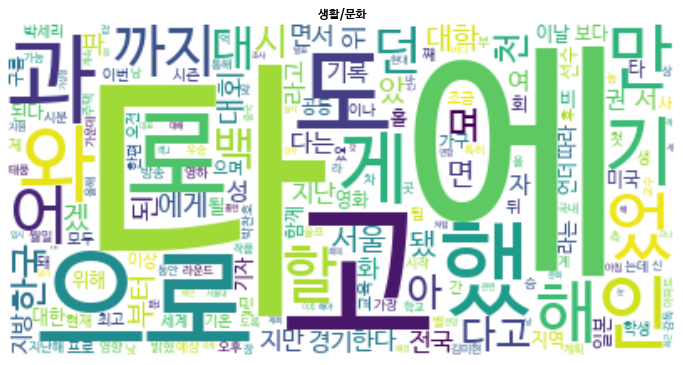

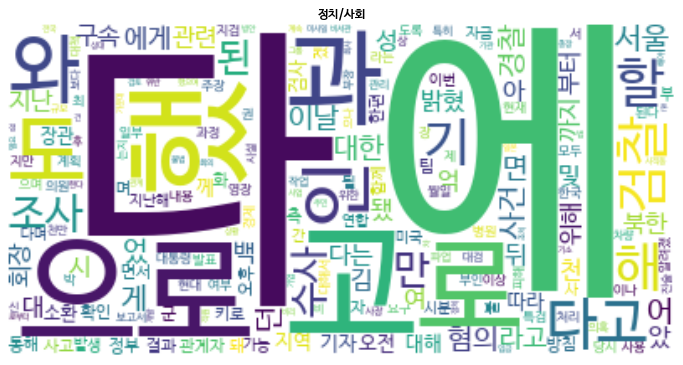

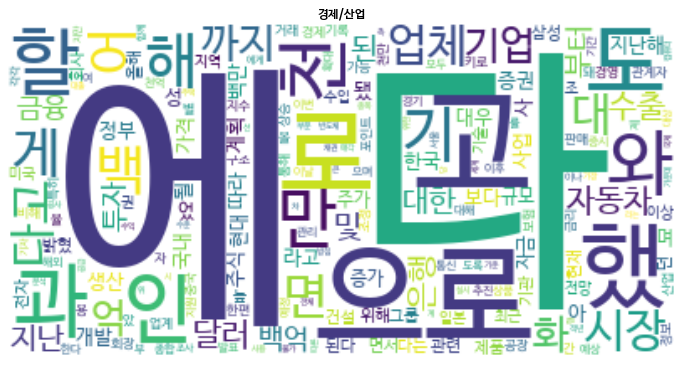

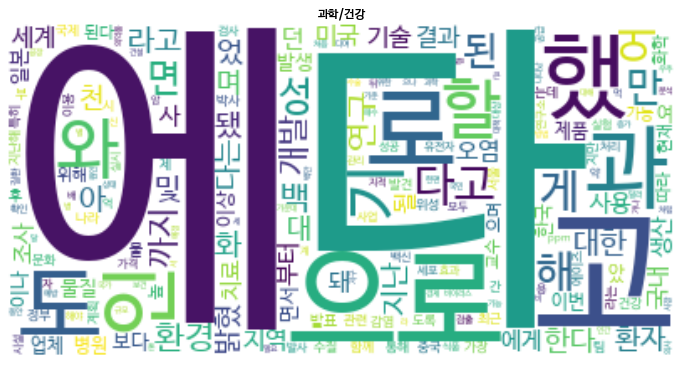

In [ ]:
for category in data['category'].unique().tolist():
    tokens_by_category = [word for tokens in data[data['category'] == category]['tokens'] for word in tokens]
    wordcloud(tokens_by_category, category)
    print('='*100)

🔥🔥🔥 

한글의 교착어 특성 때문에 에, 도, 인 등과 같은 어미가 가장 많은 빈도수를 보임..

명사만 뜯어서 봐볼까?

In [ ]:
def get_nouns_only(text, tokenizer):
    nouns = tokenizer.nouns(text)
    nouns = [n for n in nouns if n not in stop_words]
    return nouns

In [ ]:
%%time

data['nouns'] = data['doc_clean'].apply(lambda x: get_nouns_only(x, mecab))

CPU times: user 39.7 s, sys: 346 ms, total: 40 s
Wall time: 39.9 s


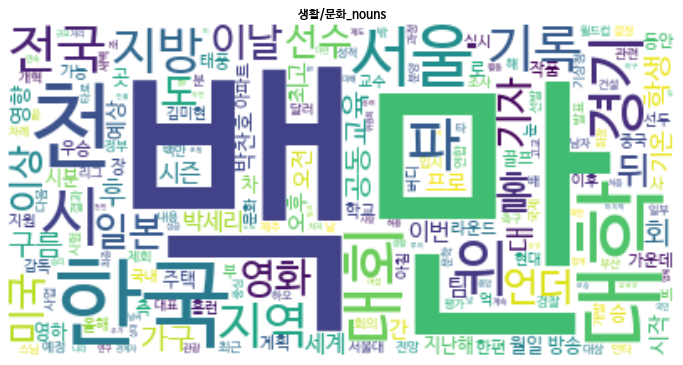

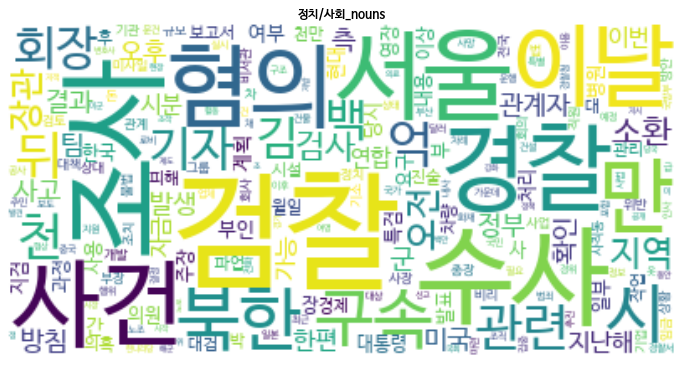

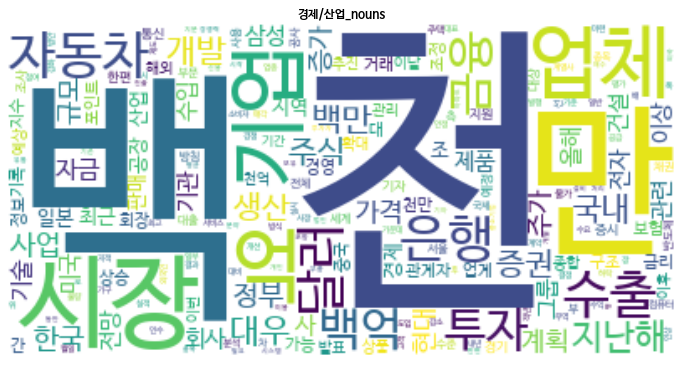

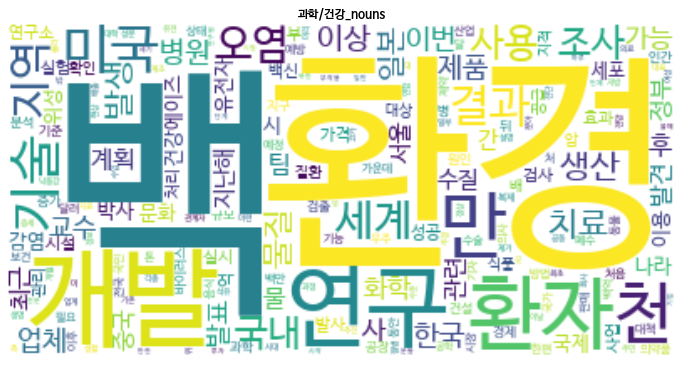

In [ ]:
for category in data['category'].unique():
    nouns_by_category = [n for nouns in data[data['category']==category]['nouns'] for n in nouns]
    wordcloud(nouns_by_category, category+'_nouns')
    print('='*100)

🔥🔥🔥 

기사 원문에서 명사만 추출 한 뒤 시각화하니 확실히 카테고리별 단어가 명확히 다른 것을 알 수 있음

In [ ]:
# data_clean.csv 저장
data.to_csv('data_clean.csv', index_label=False)

# Text Classification

In [ ]:
# data_clean.csv load
# csv를 불러올 때 리스트 타입 칼럼을 그대로 불러오기 위해 converters 파라미터 사용

data_clean = pd.read_csv('data_clean.csv', converters={'tokens':eval, 'nouns':eval})
print(data_clean.shape)
data_clean.head()

(18784, 6)


,document,category,doc_clean,tokens,class,nouns
0,여성 특유의 감성세계를 그리거나 성차별을 고발하는 내용을 담은 여성\n 취향 ...,생활/문화,여성 특유의 감성세계를 그리거나 성차별을 고발하는 내용을 담은 여성 취향 영화가 ...,"[여성, 특유, 감성, 세계, 그리, 거나, 성, 차별, 고발, 내용, 담, 여성,...",0,"[여성, 특유, 감성, 세계, 성, 차별, 고발, 내용, 여성, 취향, 영화, 조이..."
1,특별검사에 강원일-최병모\n<!-search 199910070941:hk:10:::...,정치/사회,특별검사에 강원일최병모 김대통령 임명일후 본격수사 착수 김대중 대통령은 일 조폐공...,"[특별, 검사, 에, 강원일, 최병모, 김, 대통령, 임명, 일후, 본격, 수사, ...",1,"[특별, 검사, 강원일, 최병모, 김, 대통령, 임명, 일후, 본격, 수사, 착수,..."
2,새해들어 주식시장의 기관장세화가 더욱 심화되고 있는 것으로 나타났다.\n ...,경제/산업,새해들어 주식시장의 기관장세화가 더욱 심화되고 있는 것으로 나타났다 일 증권업계에...,"[새해, 어, 주식, 시장, 기관장, 세화, 더욱, 심화, 고, 으로, 나타났, 다...",2,"[새해, 주식, 시장, 기관장, 세화, 심화, 증권업, 금융, 실명, 실시, 이후,..."
3,정부는 8일 오전 이회창총리 주재로 국무회의를 열고 우루과이라운드(UR)\n ...,경제/산업,정부는 일 오전 이회창총리 주재로 국무회의를 열고 우루과이라운드UR 협상에 따른 ...,"[정부, 오전, 이회창, 총리, 주재, 로, 국무, 회의, 열, 고, 우루과이, 라...",2,"[정부, 오전, 이회창, 총리, 주재, 국무, 회의, 우루과이, 라운드, 협상, 후..."
4,서울과 부산지하철노조가 23일 오전부터 준법운행(규정준수운행)에\n 들어간 가...,정치/사회,서울과 부산지하철노조가 일 오전부터 준법운행규정준수운행에 들어간 가운데 경찰이 이...,"[서울, 과, 부산, 지하철, 노조, 오전, 부터, 준법, 운행, 규정, 준수, 운...",1,"[서울, 부산, 지하철, 노조, 오전, 준법, 운행, 규정, 준수, 운행, 가운데,..."


In [ ]:
docs = data_clean['doc_clean'].tolist()
tokens = data_clean['tokens'].tolist()
classes = data_clean['class'].tolist()

len(docs), len(tokens), len(classes)

(18784, 18784, 18784)

## Baseline (Naive-bayse classifier)

### TF-IDF Vectorization

In [ ]:
X_train_tokens, X_test_tokens, y_train, y_test = train_test_split\
                                                                    (
                                                                     tokens, 
                                                                     classes,
                                                                     stratify=classes,
                                                                     test_size=0.2,
                                                                     random_state=34
                                                                    )

len(X_train_tokens), len(X_test_tokens), len(y_train), len(y_test)

(15027, 3757, 15027, 3757)

In [ ]:
# 토큰화 된 리스트를 그대로 사용하기 위해 형식점 함수를 토크나이저 파라미터에 넣어줌

def identify_tokenizer(text):
    return text

In [ ]:
tfidf = TfidfVectorizer(tokenizer=identify_tokenizer,
                        lowercase=False)

tfidf_X_train = tfidf.fit_transform(X_train_tokens)
tfidf_X_test = tfidf.transform(X_test_tokens)

In [ ]:
tfidf_X_train.shape, tfidf_X_test.shape

((15027, 75183), (3757, 75183))

### Naive-bayes classifier

In [ ]:
nb_clf = MultinomialNB(alpha=0.01, fit_prior=True, class_prior=None)
# alpha: 스무딩 파라미터(0이면 스무딩하지 않음)
# fit_priorr: 클래스의 사전확률을 사용할 것인지(bool)
# class_prior: 클래스의 사전확률, 지정해주면 데이터에 따라 조정되지 않음(array-like)
nb_clf.fit(tfidf_X_train, y_train)

y_pred = nb_clf.predict(tfidf_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       758
           1       0.89      0.84      0.87       986
           2       0.90      0.94      0.92      1837
           3       0.65      0.72      0.68       176

    accuracy                           0.88      3757
   macro avg       0.83      0.83      0.83      3757
weighted avg       0.88      0.88      0.88      3757



🔥🔥🔥

기본 베이스라인 모델로 naive-bayes 분류기 모델 사용

단순하게 단어의 빈도수만 고려하고 문장의 순서를 고려하지 않는다는 한계점이 있지만 생각외로 상당히 높은 성능을 보임

## DL model

### Bidirectional LSTM

In [ ]:
len(docs), len(classes)

(18784, 18784)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(docs, classes,
                                                    test_size=0.2,
                                                    stratify=classes,
                                                    random_state=34)

len(X_train), len(X_test), len(y_train), len(y_test)

(15027, 3757, 15027, 3757)

In [ ]:
print('라벨:', classes[0])
X_train[0]

라벨: 0


' 담보나 보증인 없이 신용만으로 즉시 대출을 받을 수 있는 신상품이 나왔다 한일은행은 약정서에 한번 서명으로 즉시 대출함으로써 대출절차를 간소화하고 담보를 제공하거나 보증인을 세우지 않고 신용만으로 대출을 취급하는 신상품인 한번싸인 신용대출을 개발 일부터 발매한다 이 상품은 특히 예금잔액이나 거래기간 등 과거의 거래실적에 따라 신용 대출 여부 및 대출액이 결정되는 기존의 신용대출과는 달리 신규 거래자에 대해서도 신용만으로 대출을 해준다는 특징을 갖고 있다 대출금액은 신용도에 따라 최고 천만원까지 가능하며 금리는 우대금리 현행 에다 의 가산금리를 합산한 연 로 우대금리의 오르내림에 따라 금리부담은 달라질 수도 있다 대출기간은 년으로 하되 만기 때 필요에 따라 대출기간을 연장할 수 있으며 이때 대출기간 연장으로 인해 추가로 가산금리가 적용되지 않는 것도 기존의 대출상품과 구분되는 점이다 한일은행은 직종이나 사회적인 신용도에 따라 대출대상자의 기준을 마련 했으나 직종 또는 신용도의 다양화로 기준표 작성에 현실적 어려움이 있어 일부 대상자만 선정하고 나머지는 영업점장의 재량에 맡기기로 했다 '

In [ ]:
print('라벨:', classes[-1])
X_train[-1]

라벨: 2


' 고객이 보험회사로부터 대출받은후 거래약정의 일부를 위반했을때 정당한 최고절차없이 연체이자를 부과하도록 한 보험회사의 약관이 무효화됐다 일 공정거래위원회는 대출관련 보험에 가입하고 대출을 받은 고객이 대출관련 보험계약이 무효되거나 소멸됐을때 대출약정이 소멸된 것으로 보고 정당한 통고절차없이 연체이자를 적용하도록 한 개 생명보험사와 손해보험사의 약관은 약관법에 위배된 것이라면서 관련조항을 삭제하거나 수정토록 했다 공정위는 대출과 관련한 특정보험계약이 무효가 되었더라도 다른 보험 계약이 존속되고 있는 경우 대출은 유효하며 보험계약이 완전히 상실된 경우라도 상당한 기일에 걸쳐 최고하지 않고 연체이자를 부과하는 것은 잘못이라고 그 이유를 밝혔다 또한 고객이나 보증인이 보험회사의 모든 거래 약정의 일부라도 위반 하거나 개월이상 연체했을때 회사의 서면청구에 의해 연체이자를 물릴수 있도록 한 약관도 무효화하도록 했다 공정위는 보험사의 이같은 조치는 포괄적이고 자의적인 조항으로 고객에게 부당하게 불이익을 안겨줄뿐 아니라 이미 약속한 이익을 상실시키기 위해서는 상당한 기일을 두고 최고해야할 것이라고 그 이유를 밝혔다 개 보험사는 공정위의 이같은 시정명령에 승복하고 약관을 수정하기로 동의함으로써 보험대출 이용 고객들이 앞으로 부당하게 불이익을 받지 않게 됐다 '

In [ ]:
all_tokens = [word for tokens in data_clean['tokens'] for word in tokens]
vocab = list(set(all_tokens))
vocab_size = len(vocab)

print('전체 토큰 수:', len(all_tokens))
print('중복 제외 토큰 수:', vocab_size)

전체 토큰 수: 4509845
중복 제외 토큰 수: 82077


In [ ]:
# tf keras tokenizer
tokenizer = Tokenizer(num_words=vocab_size) # 최대 단어 수=vocab_size

# 입력된 코퍼스(X_train)의 빈도수를 기준으로 단어 집합 생성
# 훈련셋 텍스트에만 fit 해주면 됨, 테스트까지하면 두번 하는 꼴임
tokenizer.fit_on_texts(X_train) 

# encoded 데이터 만들기
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

In [ ]:
# 전체 문서집합에서 각 단어에 부여된 index 확인 가능한 word_index 클래스
word_index = tokenizer.word_index
print('전체 문서의 단어 종류:', len(word_index))

maxlen = max([len(doc.split()) for doc in X_train]) # 시퀀스의 최대 길이 설정, 여기서는 가장 긴 문서를 기준으로 잡음, 잘리는 시퀀스가 없도록 하겠다는 것
embedding_dim = 128
max_features = len(word_index) + 1 # 전체 문서의 전체 단어를 다 사용하겠다는 것

전체 문서의 단어 종류: 510877


In [ ]:
maxlen, max_features

(1917, 510878)

In [ ]:
# 리스트 타입의 데이터를 (samples, maxlen) 크기의 2D 정수 텐서로 변환
X_train_padding = pad_sequences(X_train_encoded, maxlen=maxlen)
X_test_padding = pad_sequences(X_test_encoded, maxlen=maxlen)

# 리스트 타입의 데이터를 array 형태로 변환
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train_padding.shape, X_test_padding.shape, y_train.shape, y_test.shape

((15027, 1917), (3757, 1917), (15027,), (3757,))

In [ ]:
def create_BiLSTM(max_features=max_features, embedding_dim=embedding_dim, maxlen=maxlen):
    
    model = Sequential(name='BiLSTM')
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(SpatialDropout1D(0.5))

    # wrapper layer: unidirectional model => bidirectional model
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4))))
    model.add(Bidirectional(LSTM(128)))
    
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    return model

model_BiLSTM = create_BiLSTM()
model_BiLSTM.summary()

Model: "BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1917, 128)         65392384  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1917, 128)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1917, 256)         263168    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0    

In [ ]:
# checkpoint_filepath = 'BiLSTM-weights-best.hdf5'
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
#                                                          monitor='val_loss',
#                                                          verbose=1,
#                                                          mode='auto',
#                                                          save_freq='epoch',
#                                                          save_best_only=True,
#                                                          save_weights_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               mode='min',
                                               min_delta=1e-4,
                                               verbose=1,
                                               patience=3)

In [ ]:
model_BiLSTM.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

EPOCHS = 100
batch_size = 256

history = model_BiLSTM.fit(X_train_padding, y_train,
                        batch_size=batch_size,
                        epochs=EPOCHS,
                        validation_data = (X_test_padding, y_test),
                        callbacks=[checkpoint_callback, es_callback],
                        verbose=1)

Epoch 1/100
59/59 [==============================] - 79s 1s/step - loss: 0.8229 - accuracy: 0.6802 - val_loss: 0.6635 - val_accuracy: 0.7807

Epoch 00001: val_loss improved from inf to 0.66345, saving model to BiLSTM-weights-best.hdf5
Epoch 2/100
59/59 [==============================] - 70s 1s/step - loss: 0.4735 - accuracy: 0.8442 - val_loss: 0.5769 - val_accuracy: 0.8169

Epoch 00002: val_loss improved from 0.66345 to 0.57693, saving model to BiLSTM-weights-best.hdf5
Epoch 3/100
59/59 [==============================] - 70s 1s/step - loss: 0.3120 - accuracy: 0.9066 - val_loss: 0.6175 - val_accuracy: 0.8227

Epoch 00003: val_loss did not improve from 0.57693
Epoch 4/100
59/59 [==============================] - 70s 1s/step - loss: 0.2218 - accuracy: 0.9383 - val_loss: 0.6564 - val_accuracy: 0.8116

Epoch 00004: val_loss did not improve from 0.57693
Epoch 5/100
59/59 [==============================] - 70s 1s/step - loss: 0.1849 - accuracy: 0.9477 - val_loss: 0.7410 - val_accuracy: 0.8174

In [ ]:
loss, acc = model_BiLSTM.evaluate(X_test_padding, y_test, batch_size=batch_size)

15/15 [==============================] - 5s 327ms/step - loss: 0.7410 - accuracy: 0.8174


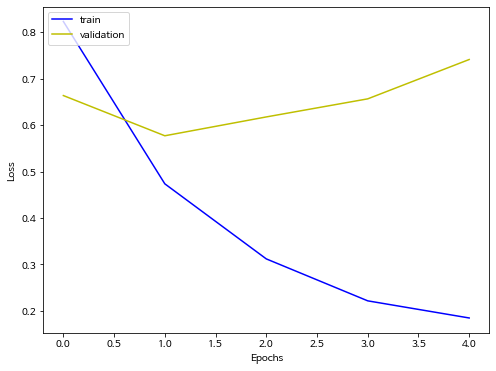

In [ ]:
fig, axes = plt.subplots(figsize=(8, 6))
axes.plot(history.history['loss'], 'b', label='train')
axes.plot(history.history['val_loss'], 'y', label='validation')
axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')
axes.legend(loc='upper left')
plt.show();

In [ ]:
y_pred = model_BiLSTM.predict(X_test_padding)
predicted_class = np.argmax(y_pred, axis=1)
print(classification_report(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       758
           1       0.88      0.77      0.82       986
           2       0.88      0.90      0.89      1837
           3       0.23      0.39      0.29       176

    accuracy                           0.82      3757
   macro avg       0.70      0.71      0.70      3757
weighted avg       0.84      0.82      0.83      3757



🔥🔥🔥 

baseline(naive-bayse 분류기) 보다 오히려 성능이 좋지 않음

걱정했던 것처럼 데이터가 적은 카테고리는 거의 맞히지 못함

데이터 불균형 문제를 해결할 필요가 있는 것 같음

# Data Agumentation
- back-translate: 한국어 -> 영어 -> 한국어
- 불균형한 과학/건강 카테고리 데이터 전체를 (영어, 일본어, 중국어)로 back-translate 하고자 했지만, 번역api는 1일 단어 수가 제한되어 있고 selenium을 활용하니 시간이 너무 오래걸려서 도중에 중단함 => 239개 생성

In [ ]:
backtrans_docs = pd.read_csv('backtrans_과학건강_317개.csv').drop(columns='Unnamed: 0')
backtrans_docs['category'] = '과학/건강'
backtrans_docs['class'] = 3
backtrans_docs.rename(columns={'0' : 'doc_clean'}, inplace=True)
print(len(backtrans_docs))
backtrans_docs.head()

317


,doc_clean,category,class
0,합성세제 생산기술 개발과 환경오염 방지를 위한 제조업체의 노력이 합성세제의 오염 유...,과학/건강,3
1,수도권 1천만 주민의 상수원인 팔당호로 유입되는 경기도 주요 하천의 오염도가 지난해...,과학/건강,3
2,이종환 삼영화 대표가 대규모 시설 증설에 나섰다. 회사 측은 BOPP가 서울 구로동...,과학/건강,3
3,"최근 구제역이 확산되면서 녹십자사는 특수를 누리고 있고, 유일하게 구제역 재발을 할...",과학/건강,3
4,"자기 비판 자기 비판은 민주주의의 비밀 무기이며, 정치적 건강을 위해서는 솔직함과 ...",과학/건강,3


In [ ]:
backtrans_docs['doc_clean'][0]

'합성세제 생산기술 개발과 환경오염 방지를 위한 제조업체의 노력이 합성세제의 오염 유발 효과를 거의 없앴지만 업계는 법 개정을 요구하고 나섰다. 한국비누세제산업연합회는 최근 환경부에 제출한 진정서에서 해수부가 수질오염을 막기 위해 구리·납 등 중금속 페놀과 독성물질과 함께 합성세제를 포함하기로 한 것은 물 건너갔다고 지적했다. 일솝세제협회에 따르면 지난해 국내에서 생산된 첫 합성세제가 생분해되기 어려운 ABS 경성세제의 주원료였고, 현재 미국과 일본의 최고수준의 천연세제와 환경보존기술이 생분해성이 높은 것으로 나타났다.노조는 그렇다고 주장한다. 비누세제협회는 계속해서 법을 개정하고 수질오염을 설명하는 하천의 비누거품 사진을 중·고교 교과서의 환경 과목에 제거하도록 요구함으로써 합성세제에 대한 잘못된 인식을 바로잡는데 주력할 것이라고 말했다.'

In [ ]:
backtrans_docs.dropna(inplace=True)

In [ ]:
backtrans_docs['doc_clean'] = backtrans_docs['doc_clean'].apply(lambda x: text_preprocessing(x))
backtrans_docs['tokens'] = backtrans_docs['doc_clean'].apply(lambda x: text_to_morphs(x, mecab))
backtrans_docs.head()

,doc_clean,category,class,tokens
0,합성세제 생산기술 개발과 환경오염 방지를 위한 제조업체의 노력이 합성세제의 오염 유...,과학/건강,3,"[합성, 세제, 생산, 기술, 개발, 과, 환경, 오염, 방지, 위한, 제조, 업체..."
1,수도권 천만 주민의 상수원인 팔당호로 유입되는 경기도 주요 하천의 오염도가 지난해보...,과학/건강,3,"[수도, 권, 천만, 주민, 상수, 원인, 팔, 당호, 로, 유입, 경기도, 주요,..."
2,이종환 삼영화 대표가 대규모 시설 증설에 나섰다 회사 측은 BOPP가 서울 구로동에...,과학/건강,3,"[이종환, 삼, 영화, 대표, 대, 규모, 시설, 증설, 에, 나섰, 다, 회사, ..."
3,최근 구제역이 확산되면서 녹십자사는 특수를 누리고 있고 유일하게 구제역 재발을 할 ...,과학/건강,3,"[최근, 구제역, 확산, 면서, 녹십자, 사, 특수, 누리, 고, 고, 유일, 게,..."
4,자기 비판 자기 비판은 민주주의의 비밀 무기이며 정치적 건강을 위해서는 솔직함과 사...,과학/건강,3,"[자기, 비판, 자기, 비판, 민주주의, 비밀, 무기, 며, 정치, 건강, 위해서,..."


In [ ]:
print('기존 데이터:')
len(docs), len(tokens), len(classes)

기존 데이터:


(18784, 18784, 18784)

In [ ]:
# 리스트에 증강데이터를 이어 붙여줌
docs.extend(backtrans_docs['doc_clean'])
tokens.extend(backtrans_docs['tokens'])
classes.extend(backtrans_docs['class'])
print('기존 데이터+증강:')
len(docs), len(tokens), len(classes)

기존 데이터+증강:


(19023, 19023, 19023)

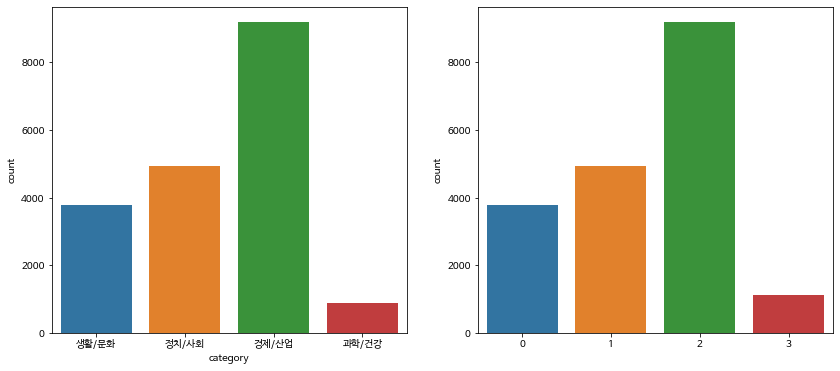

879에서 1118로 239만큼 데이터 증강


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(x=data['category'], ax=axes[0])
sns.countplot(x=classes, ax=axes[1])
plt.show();

original = data['category'].tolist().count('과학/건강')
after_agumentation = classes.count(3)

print(f'{original}에서 {after_agumentation}로 {after_agumentation-original}만큼 데이터 증강')

## Naive-bayese classifier(after agumentation)

In [ ]:
X_train_tokens, X_test_tokens, y_train, y_test = train_test_split\
                                                                    (
                                                                     tokens, 
                                                                     classes,
                                                                     stratify=classes,
                                                                     test_size=0.2,
                                                                     random_state=34
                                                                    )

len(X_train_tokens), len(X_test_tokens), len(y_train), len(y_test)

def identify_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identify_tokenizer,
                        lowercase=False)

tfidf_X_train = tfidf.fit_transform(X_train_tokens)
tfidf_X_test = tfidf.transform(X_test_tokens)

tfidf_X_train.shape, tfidf_X_test.shape

((15218, 75437), (3805, 75437))

In [ ]:
# tfidf vectorizer save
pickle.dump(tfidf, open('tfidf.pickle', 'wb'))

In [ ]:
tfidf_X_train.shape, tfidf_X_test.shape

((15218, 75437), (3805, 75437))

In [ ]:
nb_clf = MultinomialNB(alpha=0.01, fit_prior=True, class_prior=None)
nb_clf.fit(tfidf_X_train, y_train)

y_pred = nb_clf.predict(tfidf_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       758
           1       0.89      0.85      0.87       986
           2       0.89      0.94      0.91      1837
           3       0.72      0.74      0.73       224

    accuracy                           0.88      3805
   macro avg       0.85      0.84      0.84      3805
weighted avg       0.88      0.88      0.88      3805



### NB model 10-fold cv

In [ ]:
X = tfidf.fit_transform(tokens)
y = classes

In [ ]:
X.shape, len(y)

((19023, 82285), 19023)

In [ ]:
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
scoring = ['accuracy', 'f1_macro', 'f1_weighted']
cv_scores = {}

for s in scoring:
    cv_scores[s] = cross_val_score(nb_clf, X, y, scoring=s, cv=cv, n_jobs=-1)

In [ ]:
nb_10cv_df = pd.DataFrame.from_dict(cv_scores)
nb_10cv_df

,accuracy,f1_macro,f1_weighted
0,0.887546,0.849650,0.886848
1,0.896479,0.854600,0.896247
2,0.885444,0.851429,0.885639
3,0.874869,0.823699,0.874539
4,0.882229,0.848578,0.881747
5,0.881178,0.838532,0.880429
6,0.877497,0.837863,0.876475
7,0.880126,0.831362,0.879331
8,0.874343,0.834363,0.874137
9,0.876972,0.845056,0.876604


In [ ]:
nb_10cv_df.describe()

,accuracy,f1_macro,f1_weighted
count,10.000000,10.000000,10.000000
mean,0.881668,0.841513,0.881200
std,0.006753,0.009955,0.006832
min,0.874343,0.823699,0.874137
25%,0.877103,0.835238,0.876508
50%,0.880652,0.841794,0.879880
75%,0.884640,0.849382,0.884666
max,0.896479,0.854600,0.896247


In [ ]:
nb_10cv_df.to_csv('nb_10cv.csv', index_label=False)

### NB clf model save

In [ ]:
joblib.dump(nb_clf, 'nb_clf_model.pkl')

load_model = joblib.load('nb_clf_model.pkl')
y_pred = load_model.predict(tfidf_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       758
           1       0.89      0.85      0.87       986
           2       0.89      0.94      0.91      1837
           3       0.72      0.74      0.73       224

    accuracy                           0.88      3805
   macro avg       0.85      0.84      0.84      3805
weighted avg       0.88      0.88      0.88      3805



## Bidirectional LSTM(after agumentation)

In [ ]:
len(docs), len(classes), len(tokens)

(19023, 19023, 19023)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(docs, classes,
                                                    test_size=0.2,
                                                    stratify=classes,
                                                    random_state=34)

len(X_train), len(X_test), len(y_train), len(y_test)

(15218, 3805, 15218, 3805)

In [ ]:
all_tokens = [word for words in tokens for word in words]
vocab = list(set(all_tokens))
vocab_size = len(vocab)

print('전체 토큰 수:', len(all_tokens))
print('중복 제외 토큰 수:', vocab_size)

전체 토큰 수: 4536355
중복 제외 토큰 수: 82285


In [ ]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train) 

X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print('전체 문서의 단어 종류:', len(word_index))

maxlen = max([len(doc.split()) for doc in X_train])
embedding_dim = 128
max_features = len(word_index) + 1

전체 문서의 단어 종류: 512817


In [ ]:
# keras tokenizer save
pickle.dump(tokenizer, open('tokenizer.pickle', 'wb'))

In [ ]:
maxlen, max_features

(1917, 512818)

In [ ]:
X_train_padding = pad_sequences(X_train_encoded, maxlen=maxlen)
X_test_padding = pad_sequences(X_test_encoded, maxlen=maxlen)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
model = create_BiLSTM()
model.summary()

Model: "BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1917, 128)         65640704  
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 1917, 128)         0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 1917, 256)         263168    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0    

In [ ]:
# checkpoint_filepath = 'BiLSTM-weights-best-usingAugumentation.hdf5'
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
#                                                          monitor='val_loss',
#                                                          verbose=1,
#                                                          mode='auto',
#                                                          save_freq='epoch',
#                                                          save_best_only=True,
#                                                          save_weights_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               mode='min',
                                               min_delta=1e-4,
                                               verbose=1,
                                               patience=3)

In [ ]:
model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

EPOCHS = 100
batch_size = 256

history = model.fit(X_train_padding, y_train,
                        batch_size=batch_size,
                        epochs=EPOCHS,
                        validation_data=(X_test_padding, y_test),
                        callbacks=[checkpoint_callback, es_callback],
                        verbose=1)

Epoch 1/100
60/60 [==============================] - 81s 1s/step - loss: 1.0798 - accuracy: 0.5603 - val_loss: 0.7773 - val_accuracy: 0.7146

Epoch 00001: val_loss improved from inf to 0.77728, saving model to BiLSTM-weights-best-usingAugumentation.hdf5
Epoch 2/100
60/60 [==============================] - 72s 1s/step - loss: 0.5574 - accuracy: 0.8123 - val_loss: 0.6011 - val_accuracy: 0.8053

Epoch 00002: val_loss improved from 0.77728 to 0.60115, saving model to BiLSTM-weights-best-usingAugumentation.hdf5
Epoch 3/100
60/60 [==============================] - 72s 1s/step - loss: 0.3389 - accuracy: 0.8958 - val_loss: 0.6692 - val_accuracy: 0.7758

Epoch 00003: val_loss did not improve from 0.60115
Epoch 4/100
60/60 [==============================] - 72s 1s/step - loss: 0.2112 - accuracy: 0.9388 - val_loss: 0.6983 - val_accuracy: 0.8066

Epoch 00004: val_loss did not improve from 0.60115
Epoch 5/100
60/60 [==============================] - 72s 1s/step - loss: 0.1568 - accuracy: 0.9618 - v

In [ ]:
y_pred = model.predict(X_test_padding)
predicted_class = np.argmax(y_pred, axis=1)
print(classification_report(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.85      0.67      0.75       758
           1       0.82      0.80      0.81       986
           2       0.88      0.89      0.88      1837
           3       0.36      0.62      0.46       224

    accuracy                           0.81      3805
   macro avg       0.73      0.74      0.72      3805
weighted avg       0.83      0.81      0.81      3805



In [ ]:
print('weighted:', f1_score(y_test, predicted_class, average='weighted'))
print('macro:', f1_score(y_test, predicted_class, average='macro'))
print('micro:', f1_score(y_test, predicted_class, average='micro'))

weighted: 0.8126547400425719
macro: 0.7248440125920256
micro: 0.8065703022339029



- **average=micro says** 

    the function to compute f1 by considering total true positives, false
    negatives and false positives (no matter of the prediction for each 
    label in the dataset)

- **average=macro says** 
    
    the function to compute f1 for each label, and returns the average 
    without considering the proportion for each label in the dataset.

- **average=weighted says** 
    
    the function to compute f1 for each label, and returns the average 
    considering the proportion for each label in the dataset.

### Load model-weights(BiLSTM)

In [ ]:
max_features = 512818
embedding_dim = 128 
maxlen = 1917

def create_BiLSTM(max_features=max_features, embedding_dim=embedding_dim, maxlen=maxlen):
    
    model = Sequential(name='BiLSTM')
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(SpatialDropout1D(0.5))

    # wrapper layer: unidirectional model => bidirectional model
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4))))
    model.add(Bidirectional(LSTM(128)))
    
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    return model

model = create_BiLSTM()
model.summary()

Model: "BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1917, 128)         65640704  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1917, 128)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1917, 256)         263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0    

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.load_weights('BiLSTM-weights-best-usingAugumentation.hdf5')
loss, acc = model.evaluate(X_test_padding, y_test, batch_size=batch_size)

15/15 [==============================] - 10s 326ms/step - loss: 0.6011 - accuracy: 0.8053


### BiLSTM 10-fold cv

In [ ]:
X_train_padding.shape, X_test_padding.shape, y_train.shape, y_test.shape

((15218, 1917), (3805, 1917), (15218,), (3805,))

In [ ]:
X_padding = np.concatenate((X_train_padding, X_test_padding), axis=0)
y_padding = np.concatenate((y_train, y_test), axis=0)
X_padding.shape, y_padding.shape

((19023, 1917), (19023,))

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=34)
cv_acc = []
cv_weighted = []
cv_macro = []
cv_micro = []

for train_idx, test_idx in kfold.split(X_padding, y_padding):
    model = create_BiLSTM()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_padding[train_idx], y_padding[train_idx], epochs=5, batch_size=batch_size, verbose=1)

    loss, acc = model.evaluate(X_padding[test_idx], y_padding[test_idx], verbose=0)

    print(f'{model.metrics_names[1]}: {acc}')
    print(f'{model.metrics_names[0]}: {loss}')

    y_pred = model.predict(X_padding[test_idx])
    predicted_class = np.argmax(y_pred, axis=1)
    print(classification_report(y_padding[test_idx], predicted_class))
    
    cv_acc.append(acc)
    cv_weighted.append(f1_score(y_padding[test_idx], predicted_class, average='weighted'))
    cv_macro.append(f1_score(y_padding[test_idx], predicted_class, average='macro'))
    cv_micro.append(f1_score(y_padding[test_idx], predicted_class, average='micro'))
    
    print('='*100)

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       379
           1       0.86      0.79      0.82       493
           2       0.88      0.90      0.89       918
           3       0.40      0.59      0.48       112

    accuracy                           0.82      1902
   macro avg       0.74      0.75      0.74      1902
weighted avg       0.83      0.82      0.82      1902

Epoch 1/5
67/67 [==============================] - 74s 1s/step - loss: 1.0638 - accuracy: 0.5656
Epoch 2/5
67/67 [==============================] - 68s 1s/step - loss: 0.5607 - accuracy: 0.8133
Epoch 3/5
67/67 [==============================] - 68s 1s/step - loss: 0.3290 - accuracy: 0.8955
Epoch 4/5
67/67 [==============================] - 68s 1s/step - loss: 0.2244 - accuracy: 0.9352
Epoch 5/5
67/67 [==============================] - 68s 1s/step - loss: 0.1777 - accuracy: 0.9555
accuracy: 0.8222923278808594
loss: 0.737648606300354
              precision    

In [ ]:
lstm_10cv_df = pd.DataFrame(columns=['acc', 'weighted', 'macro', 'micro'])
lstm_10cv_df['acc'] = cv_acc
lstm_10cv_df['weighted'] = cv_weighted
lstm_10cv_df['macro'] = cv_macro
lstm_10cv_df['micro'] = cv_micro

lstm_10cv_df

,acc,weighted,macro,micro
0,0.812401,0.814266,0.720324,0.812401
1,0.812401,0.812323,0.722154,0.812401
2,0.821335,0.824197,0.733018,0.821335
3,0.818086,0.824401,0.717960,0.818086
4,0.827024,0.831134,0.729389,0.827024
5,0.801788,0.813983,0.719259,0.801788
6,0.823870,0.825601,0.751917,0.823870
7,0.815457,0.826806,0.735894,0.815457
8,0.821241,0.824807,0.740868,0.821241
9,0.822292,0.823207,0.724994,0.822292


In [ ]:
lstm_10cv_df.describe()

,acc,weighted,macro,micro
count,10.000000,10.000000,10.000000,10.000000
mean,0.817590,0.822072,0.729578,0.817590
std,0.007350,0.006299,0.010962,0.007350
min,0.801788,0.812323,0.717960,0.801788
25%,0.813165,0.816501,0.720781,0.813165
50%,0.819663,0.824299,0.727192,0.819664
75%,0.822053,0.825402,0.735175,0.822053
max,0.827024,0.831134,0.751917,0.827024


In [ ]:
lstm_10cv_df.to_csv('lstm_10cv.csv', index_label=False)

### Keras-tuner

In [ ]:
max_features, embedding_dim, maxlen

(512818, 128, 1917)

In [ ]:
def model_builder(hp):
    model = Sequential(name='BiLSTM-kerastuner')
    
    hp_bidirectional = hp.Int('bidirectional', min_value=128, max_value=256, step=32)
    hp_dense = hp.Int('dense', min_value=64, max_value=512, step=64)
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid', 'elu'], default='relu')
    hp_dropout1d = hp.Float('dropout1d', min_value=0.3, max_value=0.6, step=0.1)
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.6, step=0.1)
    hp_regularizer = hp.Choice('regularizer', values=[1e-3, 1e-4, 1e-5, 1e-6])
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])

    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(SpatialDropout1D(hp_dropout1d))

    model.add(Bidirectional(LSTM(hp_bidirectional, return_sequences=True, kernel_regularizer=regularizers.l2(hp_regularizer))))
    model.add(Bidirectional(LSTM(hp_bidirectional)))

    model.add(Dropout(hp_dropout))
    model.add(Dense(hp_dense, activation=hp_activation, kernel_regularizer=regularizers.l2(hp_regularizer)))

    model.add(Dropout(hp_dropout))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(
                     model_builder,
                     objective='val_loss',
                     seed=34,
                     max_epochs=10, # 모델을 학습할 최대 epoch
                     executions_per_trial=3, # 각 trial 내에 구축할 모델 수
                     directory='kerastuning',
                     project_name='BiLSTM_clf_tuning'
)

🔥 Hyperband는 1 + log"factor"^(max_epochs)^ 를 계산하고 이를 가장 가까운 정수로 반올림하여 한 브래킷에서 훈련할 모델 수를 결정

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [ ]:
X_train_padding.shape, y_train.shape, X_test_padding.shape, y_test.shape

((15218, 1917), (15218,), (3805, 1917), (3805,))

In [ ]:
tuner.search(X_train_padding, y_train,
             epochs=10,
             batch_size=128,
             validation_data=(X_test_padding, y_test),
             callbacks=[ClearTrainingOutput(), es_callback])

# 램이 너무 터져서 batch_size를 256에서 128로 줄임
# 구글드라이브 용량이 터지는 관계로...interrupt.. 현재까지 돌아간 결과만 확인

Epoch 3/4
 12/119 [==>...........................] - ETA: 1:49 - loss: 1.3190 - accuracy: 0.4290

KeyboardInterrupt: ignored

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
[Best hyperparameters]
bidirectional: {best_hps.get('bidirectional')}
dense: {best_hps.get('dense')}
activation: {best_hps.get('activation')}
dropout_1d: {best_hps.get('dropout1d')}
dropout: {best_hps.get('dropout')}
regularizer: {best_hps.get('regularizer')}
learning_rate: {best_hps.get('learning_rate')}
""")


[Best hyperparameters]
bidirectional: 160
dense: 448
activation: tanh
dropout_1d: 0.3
dropout: 0.4
regularizer: 1e-06
learning_rate: 0.001



In [ ]:
model_hp = tuner.hypermodel.build(best_hps)
model_hp.summary()

Model: "BiLSTM-kerastuner"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1917, 128)         65640704  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1917, 128)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1917, 320)         369920    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 320)               615680    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 448)               143808    
_________________________________________________________________
dropout_1 (Dropout)          (None, 448)         

In [ ]:
# 하이퍼파라미터 최적값으로 모델 튜닝 및 재학습

# checkpoint_filepath = 'BiLSTM-weights-best-usingAugumentation-kerastuner.hdf5'
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
#                                                          monitor='val_loss',
#                                                          verbose=1,
#                                                          mode='auto',
#                                                          save_freq='epoch',
#                                                          save_best_only=True,
#                                                          save_weights_only=True)

history = model_hp.fit(X_train_padding, y_train,
                       batch_size=128,
                       epochs=50,
                       validation_data=(X_test_padding, y_test),
                       callbacks=[checkpoint_callback, es_callback],
                       verbose=1)

119/119 [==============================] - 116s 974ms/step - loss: 0.1631 - accuracy: 0.9545 - val_loss: 0.6886 - val_accuracy: 0.8218

Epoch 00003: val_loss did not improve from 0.59943
Epoch 4/50
119/119 [==============================] - 116s 976ms/step - loss: 0.1012 - accuracy: 0.9746 - val_loss: 0.6355 - val_accuracy: 0.8310

Epoch 00004: val_loss did not improve from 0.59943
Epoch 00004: early stopping


In [ ]:
y_pred = model_hp.predict(X_test_padding)
predicted_class = np.argmax(y_pred, axis=1)
print(classification_report(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78       758
           1       0.83      0.82      0.82       986
           2       0.85      0.92      0.89      1837
           3       0.57      0.49      0.53       224

    accuracy                           0.83      3805
   macro avg       0.78      0.74      0.75      3805
weighted avg       0.83      0.83      0.83      3805



In [ ]:
lstm_kt_df = pd.DataFrame(columns=['acc', 'weighted', 'macro', 'micro'])
lstm_kt_df['acc'] = [acc]
lstm_kt_df['weighted'] = [f1_score(y_test, predicted_class, average='weighted')]
lstm_kt_df['macro'] = [f1_score(y_test, predicted_class, average='macro')]
lstm_kt_df['micro'] = [f1_score(y_test, predicted_class, average='micro')]
lstm_kt_df.to_csv('lstm_kt.csv', index_label=False)

# clf Model scoring comparison
- Naive-bayse classifier (ML baseline)
- BiLSTM (DL baseline)
- BiLSTM with optimal hyperparameters (DL optimal)

In [40]:
NB = pd.read_csv('nb_10cv.csv')
BiLSTM = pd.read_csv('lstm_10cv.csv')
BiLSTM_kt = pd.read_csv('lstm_kt.csv')

In [41]:
NB

,acc,macro,weighted
0,0.887546,0.849650,0.886848
1,0.896479,0.854600,0.896247
2,0.885444,0.851429,0.885639
3,0.874869,0.823699,0.874539
4,0.882229,0.848578,0.881747
5,0.881178,0.838532,0.880429
6,0.877497,0.837863,0.876475
7,0.880126,0.831362,0.879331
8,0.874343,0.834363,0.874137
9,0.876972,0.845056,0.876604


In [46]:
for col in NB.columns:
    print(col)
    print(NB[col].mean())

acc
0.8816682718580934
macro
0.8415134358115364
weighted
0.8811995302001066


In [47]:
BiLSTM

,acc,weighted,macro,micro
0,0.812401,0.814266,0.720324,0.812401
1,0.812401,0.812323,0.722154,0.812401
2,0.821335,0.824197,0.733018,0.821335
3,0.818086,0.824401,0.717960,0.818086
4,0.827024,0.831134,0.729389,0.827024
5,0.801788,0.813983,0.719259,0.801788
6,0.823870,0.825601,0.751917,0.823870
7,0.815457,0.826806,0.735894,0.815457
8,0.821241,0.824807,0.740868,0.821241
9,0.822292,0.823207,0.724994,0.822292


In [48]:
for col in BiLSTM.columns:
    print(col)
    print(BiLSTM[col].mean())

acc
0.8175895750522614
weighted
0.8220724882889096
macro
0.7295777884279058
micro
0.8175895826668059


In [ ]:
BiLSTM_kt

,acc,weighted,macro,micro
0,0.831012,0.827902,0.754593,0.831012
1,0.831012,0.827902,0.754593,0.831012
2,0.831012,0.827902,0.754593,0.831012
3,0.831012,0.827902,0.754593,0.831012
4,0.831012,0.827902,0.754593,0.831012
5,0.831012,0.827902,0.754593,0.831012
6,0.831012,0.827902,0.754593,0.831012
7,0.831012,0.827902,0.754593,0.831012
8,0.831012,0.827902,0.754593,0.831012
9,0.831012,0.827902,0.754593,0.831012


In [ ]:
def scoring_plot(metric):
    plt.figure(figsize=(12, 6))
    plt.plot(NB[metric], '--', color='b', alpha=.3, label='Naive-Bayse')
    plt.plot([NB[metric].mean()]*10, '-', color='b', label='CV Mean')

    plt.plot(BiLSTM[metric], '--', color='g', alpha=.3, label='BiLSTM')
    plt.plot([BiLSTM[metric].mean()]*10, '-', color='g', label='CV Mean')

    plt.plot(BiLSTM_kt[metric], '-', color='r', label='BiLSTM-tuned')
    
    plt.yticks(np.arange(0.6, 0.9, 0.05))
    plt.xticks(np.arange(10))
    plt.ylabel('scores', fontsize=12)
    
    plt.title(metric, weight='bold', fontsize=18)
    plt.legend(fontsize=12, loc='lower left')
    plt.grid(alpha=.5)
    
    plt.show();

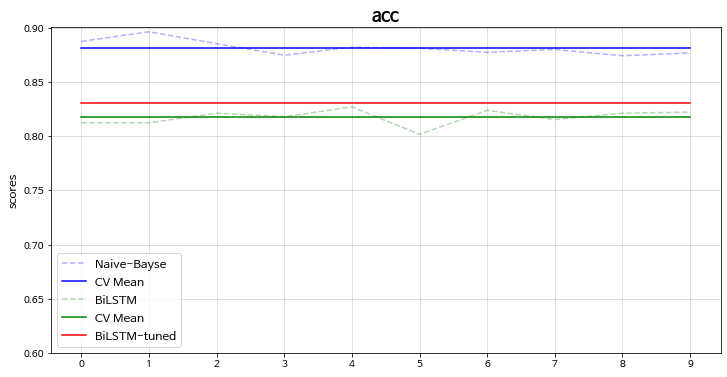

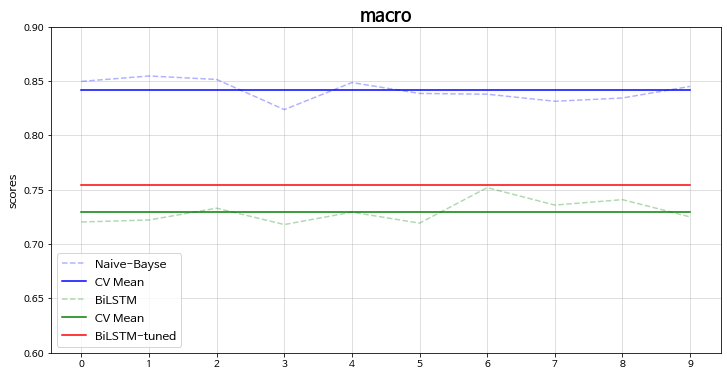

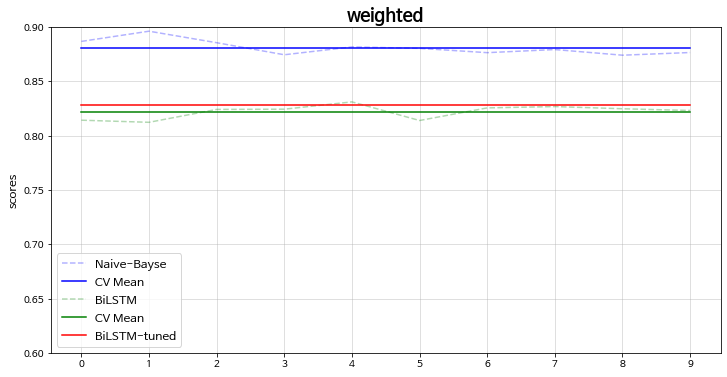

In [ ]:
metrics = ['acc', 'macro', 'weighted']
for m in metrics:
    scoring_plot(m)
    print('='*100)

# Usage Flow Example

## pororo summarizer

In [11]:
# pororo summarization method
get_summary_abs = Pororo(task='summary', lang='kr', model='abstractive')
get_summary_ext = Pororo(task='summary', lang='kr', model='extractive')

## news-crwawler

In [1]:
def rknews_crwaler(n_news):
    print('뉴스를 가져오는 중입니다...')
    # n_news: 불러 올 뉴스 기사 수
    base_url= "https://news.naver.com/main/ranking/popularDay.nhn?mid=etc&sid1=111"
    headers = {'User-Agent': 'Mozilla/5.0'} # 403에러가 뜰 때 헤더를 추가해주면 접근할 수 있음
    response = requests.get(base_url, headers=headers)

    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
    else : 
        print(response.status_code)

    news_url_lst = []

    info = soup.findAll('div', {'class': 'list_content'})
    for each in info:
        each_news = each.findAll('a', {'class': "list_title nclicks('RBP.rnknws')"})
        news_url = 'https://news.naver.com/' + each_news[0].get('href')
        news_url_lst.append(news_url)

    text_lst = []

    for news_url in news_url_lst[:n_news]: # 크롤링해올 뉴스 개수
        res_article= requests.get(news_url, headers=headers)

        if res_article.status_code == 200:
            html_article = res_article.text
            soup_article = BeautifulSoup(html_article, 'html.parser')
        else : 
            print(res_article.status_code)

        text = soup_article.findAll('div', {'class':'_article_body_contents'})[0].text

        if text == []:
            continue

        # if '▶' in text:
        #     try:
        #         text = text.split('▶')[:-5][0]
        #     except IndexError:
        #         pass

        text = ' '.join(text.split('\n')[8:])
        text = '.'.join(text.split('.')[:-2])
        text_lst.append(text)
    
    print(f'실시간 랭킹 뉴스 {len(text_lst)}개를 가져왔습니다.')
    return text_lst

## Cleaning

In [2]:
def get_cleaning_lst(texts):

    print('텍스트를 정제중입니다...')
    def text_cleaning_get_tokens(text):

        mecab = Mecab()

        def text_preprocessing(txt):
            find_email = '[a-zA-Z0-9]+[\._]?[a-z0-9]+[@]+[a-zA-Z0-9]'
            get_email = re.search(find_email, txt)
            if get_email:
                txt = txt[:get_email.start()] + txt[get_email.end():]
            txt = re.sub('[^가-힣a-zA-Z ]', '', txt)
            txt = re.sub('[ ]+', ' ', txt)
            remove_msg = re.search('flash 오류를 우회하기 위한 함수 추가 function flashremoveCallback', txt)
            if remove_msg != None:
                txt = txt[:remove_msg.start()] + txt[remove_msg.end():]
            remove_msg = re.search('코로나 현황 속보 가장 확실한 SBS 제보 클릭 제보하기', txt)
            if remove_msg != None:
                txt = txt[:remove_msg.start()] + txt[remove_msg.end():]
            txt = txt.replace('앵커', '')

            txt = txt.strip()
            return txt

        def text_to_morphs(txt, tokenizer=mecab):
            stop_words = pd.read_csv('한국어불용어100.txt', sep='\t', header=None)
            stop_words = stop_words[0].tolist()
            add_stop_words = ['에서', '의', '을', '를', '이', '가', '는', '은', 'search', '에', '앵커', '기자']
            for word in add_stop_words:
                stop_words.append(word)
            stop_words = list(set(stop_words))

            morphs = tokenizer.morphs(txt)
            tokens = [m for m in morphs if m not in stop_words]
            return tokens

        text = text_preprocessing(text)
        tokens = text_to_morphs(text)

        return text, tokens


    tokens_lst = []
    clean_text_lst = []
    abs_summary_lst = []
    ext_summary_lst = []
    
    for text in texts:
        clean_text, tokens = text_cleaning_get_tokens(text)
        tokens_lst.append(tokens)
        clean_text_lst.append(clean_text)
        abs_summary_lst.append(get_summary_abs(clean_text))
        ext_summary_lst.append(get_summary_ext(clean_text))
    
    return tokens_lst, clean_text_lst, abs_summary_lst, ext_summary_lst

## Models

In [3]:
### NB model create
    
# tfidf vectorizer load
def identify_tokenizer(text):
    return text

# vectorizer = pickle.load(open('tfidf.pickle', 'rb')) # 저장한 벡터라이져에 사용된 함수가 있어야 불러올 수 있음

# X = vectorizer.transform(tokens_lst)

def create_NB_model():
    model = joblib.load('nb_clf_model.pkl')
    return model

# NB_clf = create_NB_model()

In [4]:
## BiLSTM model create
max_features = 512818
embedding_dim = 128
maxlen = 1917

# 튜닝모델의 학습 가중치를 불러와서 모델 정의할 때 사용할 수 있는 모델 생성 함수
def create_tuner_model():
    

    model = Sequential()
    
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(SpatialDropout1D(0.3))

    model.add(Bidirectional(LSTM(160, return_sequences=True, kernel_regularizer=regularizers.l2(1e-06))))
    model.add(Bidirectional(LSTM(160)))

    model.add(Dropout(0.4))
    model.add(Dense(448, activation='tanh', kernel_regularizer=regularizers.l2(1e-06)))

    model.add(Dropout(0.4))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# # load tokenizer
# tokenizer = pickle.load(open('tokenizer.pickle', 'rb'))
# # text data -> encoded data -> padding data
# X_encoded = tokenizer.texts_to_sequences(clean_text_lst)
# X_padding = pad_sequences(X_encoded, maxlen=maxlen)
# # load model weights
# BiLSTM_clf = create_tuner_model()
# BiLSTM_clf.load_weights('BiLSTM-weights-best-usingAugumentation-kerastuner.hdf5')

In [31]:
# # naive-bayse category prediction
# pred_class_lst_nb = NB_clf.predict(X)
# pred_proba_lst_nb = [max(x) for x in NB_clf.predict_proba(X)]

# # bilstm categoty prediction
# pred_bi = BiLSTM_clf.predict(X_padding)
# pred_proba_lst_bi = [max(x) for x in pred_bi]
# pred_class_lst_bi = np.argmax(pred_bi, axis=1)

## Result

In [5]:
def show_result(model, summarizer, texts,
                pred_class_lst_nb, pred_proba_lst_nb,
                pred_class_lst_bi, pred_proba_lst_bi,
                abs_summary_lst, ext_summary_lst):
    
    category_dict = {0:'생활/문화',
                     1:'정치/사회',
                     2:'경제/산업',
                     3:'과학/건강'}

    def print_by_length(text):
        '''
        코랩 노트북에서 print()하면 텍스트가 1열로 나와서 가독성이 안좋음
        텍스트 길이 100을 기준으로 잘라서 출력해주는 함수 구현
        '''
        if len(text) > 100:    
            start = 0
            end = 100
            for _ in range(1, int(len(text) / 100)+2):
                print(text[start:end])
                start = end
                end += 100
        else:
            print(text)


    for i in range(len(texts)):
        print('[Original:]')
        print_by_length(texts[i])
        print('\n')

        print('[Category:]')
        if model == 'Naive-Bayes':
            # print('Naive-Bayse Classifier =>')
            print(f'{category_dict[pred_class_lst_nb[i]]} in {round(pred_proba_lst_nb[i]*100, 2)}%',)
        if model == 'BiLSTM':
            # print('BiLSTM Classifier => ')
            print(f'{category_dict[pred_class_lst_bi[i]]} in {round(pred_proba_lst_bi[i]*100, 2)}%')
        print('\n')

        print('[Summarization:]')
        if summarizer == 'Abstractive':
            # print('Abstraction =>')
            print_by_length(abs_summary_lst[i])
        if summarizer == 'Extractive':
            # print('Extraction =>')
            print_by_length(ext_summary_lst[i])
        print('\n')

        print('='*150, '\n')

In [6]:
from ipywidgets import widgets
from IPython.display import display, clear_output
#https://ichi.pro/ko/jupyter-wijes-eul-hwal-yong-han-jadonghwa-doen-yecheug-jeobgeun-bangsig-22176733451028

In [7]:
def widget():
    # widgets buttons
    models = ('Naive-Bayes', 'BiLSTM')
    summarizers = ('Abstractive', 'Extractive')
   
    newsnum = widgets.BoundedIntText(value=5, min=1, max=10, step=1, description='Article cnt', disabled=False, layout=widgets.Layout(width='25%', height='40px'))                         
    model_select = widgets.Dropdown(options=models, description='Classifier', layout=widgets.Layout(width='25%', height='40px'))
    summarizer_select = widgets.Dropdown(options=summarizers, description='Summarizer', layout=widgets.Layout(width='25%', height='40px'))
    getnews = widgets.Button(description='Check Ranking News', layout=widgets.Layout(width='25%', height='80px'))
    output = widgets.Output()
    clear = widgets.Button(description='Clear all', layout=widgets.Layout(width='25%', height='40px'))
    
    def getnews_click(b):
        texts = rknews_crwaler(newsnum.value)
        tokens_lst, clean_text_lst, abs_summary_lst, ext_summary_lst = get_cleaning_lst(texts)
        
        print('기사를 요약중입니다. 잠시만 기다려주세요!')
        
        vectorizer = pickle.load(open('tfidf.pickle', 'rb'))
        X = vectorizer.transform(tokens_lst)
        NB_clf = create_NB_model()
        
        tokenizer = pickle.load(open('tokenizer.pickle', 'rb'))
        X_encoded = tokenizer.texts_to_sequences(clean_text_lst)
        X_padding = pad_sequences(X_encoded, maxlen=maxlen)
        BiLSTM_clf = create_tuner_model()
        BiLSTM_clf.load_weights('BiLSTM-weights-best-usingAugumentation-kerastuner.hdf5')

        pred_class_lst_nb = NB_clf.predict(X)
        pred_proba_lst_nb = [max(x) for x in NB_clf.predict_proba(X)]
        pred_bi = BiLSTM_clf.predict(X_padding)
        pred_proba_lst_bi = [max(x) for x in pred_bi]
        pred_class_lst_bi = np.argmax(pred_bi, axis=1)
    
        model = model_select.value
        summarizer = summarizer_select.value

        with output:
            clear_output()
            show_result(model, summarizer, texts,
                        pred_class_lst_nb, pred_proba_lst_nb,
                        pred_class_lst_bi, pred_proba_lst_bi,
                        abs_summary_lst, ext_summary_lst)


    def clear_all(b):
        with output:
            clear_output()
            print('='*150)
            

    display(newsnum, model_select, summarizer_select, getnews, clear, output)
    getnews.on_click(getnews_click)
    clear.on_click(clear_all)

In [12]:
widget()

BoundedIntText(value=5, description='Article cnt', layout=Layout(height='40px', width='25%'), max=10, min=1)

Dropdown(description='Classifier', layout=Layout(height='40px', width='25%'), options=('Naive-Bayes', 'BiLSTM'…

Dropdown(description='Summarizer', layout=Layout(height='40px', width='25%'), options=('Abstractive', 'Extract…

Button(description='Check Ranking News', layout=Layout(height='80px', width='25%'), style=ButtonStyle())

Button(description='Clear all', layout=Layout(height='40px', width='25%'), style=ButtonStyle())

Output()

뉴스를 가져오는 중입니다...
실시간 랭킹 뉴스 5개를 가져왔습니다.
텍스트를 정제중입니다...
기사를 요약중입니다. 잠시만 기다려주세요!
